In [4]:
from typing import Dict, List, Tuple
import torch
import numpy as np
import gym
from plotly.subplots import make_subplots
from agent.DQN_Agent import DQNAgent
from environment.DiscreteEnvironment import DiscreteSimpleEnvironment

import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set environment and agent parameters

In [5]:
env_arguments = {
"alpha":1,
"beta":1,
"min_temp" : 16,
"max_temp" : 21,
"action_dim": 100,
"modelname":'CELLS_v1.fmu',
"simulation_path":  r'C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\EnergyPlus_simulations\simple_simulation',
"param_list": ['Tair', 'RH', 'Tmrt', 'Tout', 'Qheat', 'Occ'],
"days": 151,  
"hours": 24,  
"minutes": 60,
"seconds": 60,
"ep_timestep": 6
}

env = DiscreteSimpleEnvironment(param_list=['Tair', 'RH', 'Tmrt', 'Tout', 'Qheat', 'Occ'],
alpha=1,
beta=1,
min_temp=16,
max_temp=21,
discrete_action_dim=100,
modelname='CELLS_v1.fmu',
simulation_path=r'C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\EnergyPlus_simulations\simple_simulation',
days=151,
hours=24,
minutes=60,
seconds=60,
ep_timestep=6)

agent_arguments = {
"memory_size": [1000],
"batch_size": [32],
"actor_update":[2],
"target_update": [100],
"epsilon_decay": [1 / 20000],
"max_epsilon": [1],
"min_epsilon":  [0.0],
"lr":[1e-3],
"gamma": [0.99],
"inside_dim": [128],
"num_hidden_layers": [1],
"seed": [778]
}

def cumulative_reward(data:pd.DataFrame) -> float:
    return np.cumsum(np.array(data["Reward"]))[-1]

Iteration0
Iteration1000
Iteration2000
Iteration3000
Iteration4000
Iteration5000
Iteration6000
Iteration7000
Iteration8000
Iteration9000
Iteration10000
Iteration11000
Iteration12000
Iteration13000
Iteration14000
Iteration15000
Iteration16000
Iteration17000
Iteration18000
Iteration19000
Iteration20000
Iteration21000


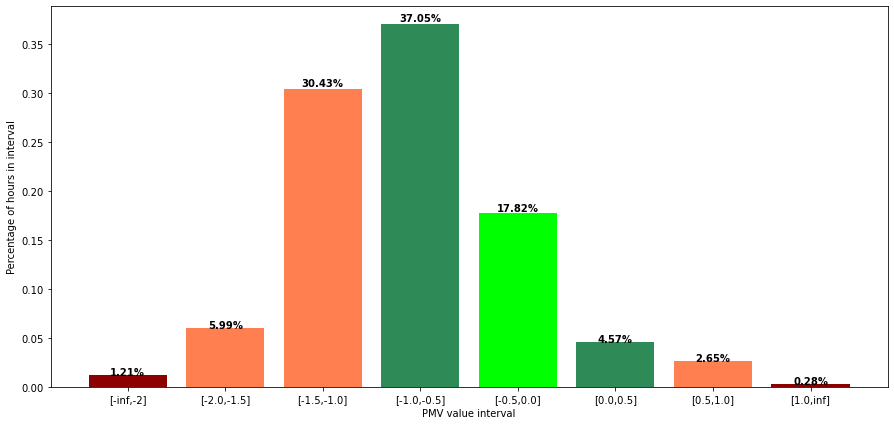

In [8]:
from environment.DiscreteEnvironment import DiscreteSimpleEnvironment
from agent.DQN_Agent import DQNAgent

env = DiscreteSimpleEnvironment()
agent = DQNAgent(env)

## please put the absolute path to the ICCP project
logging_path = r"C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\logs\simple_simulation"
results_path, summary_df = agent.train(logging_path= logging_path, num_episodes=1)

In [6]:
from Performance import all_combinations_list

best_reward = -np.inf
best_path = ""

logging_path = r"C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\logs\simple_simulation"

for curr_agent_arguments in all_combinations_list(agent_arguments):

    agent = DQNAgent(env).from_dict(dict_arguments=curr_agent_arguments)
    results_path, summary_df = agent.train(logging_path= logging_path, num_episodes=1, num_iterations=200 ,log=True)
    total_cum_reward = cumulative_reward(summary_df)
    if total_cum_reward > best_reward:
        best_reward = total_cum_reward
        best_path = results_path
  

best_path



FileNotFoundError: [WinError 3] The system cannot find the path specified: '.\\logs\\simple_simulation'

In [ ]:
l = [[{'secondary_y': False}], [{'secondary_y': True}], [{'secondary_y': False}], [{'secondary_y': True}], [{'secondary_y': True}], [{'secondary_y': False}], [{'secondary_y': False}], [{'secondary_y': False}]]

len(l)

In [1]:
# Example of how to use the function: 
import Performance

searching_directory = r"C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\logs\simple_simulation\results\DQN_Agent"

conditions={
    "is_test":["=",False],
    "num_iterations": ["=",21744], # to only have have trainings where the full simulation was used
    #"num_episodes":["=",3],
    "alpha":["=",1],
    "beta":["=",1],
    "num_hidden_layers":[">",2]
}

conditions = {}

path_list = Performance.search_paths(searching_directory,conditions=conditions, top_k=20, utility_function=Performance.cumulative_reward,normalized=True)

In [2]:
path_list

['C:\\Users\\Harold\\Desktop\\ENAC-Semester-Project\\DIET_Controller\\logs\\simple_simulation\\results\\DQN_Agent\\2022_5_2\\results_2022_5_2_22_53',
 'C:\\Users\\Harold\\Desktop\\ENAC-Semester-Project\\DIET_Controller\\logs\\simple_simulation\\results\\DQN_Agent\\2022_5_2\\results_2022_5_2_22_53',
 'C:\\Users\\Harold\\Desktop\\ENAC-Semester-Project\\DIET_Controller\\logs\\simple_simulation\\results\\DQN_Agent\\2022_5_2\\results_2022_5_2_23_8',
 'C:\\Users\\Harold\\Desktop\\ENAC-Semester-Project\\DIET_Controller\\logs\\simple_simulation\\results\\DQN_Agent\\2022_5_2\\results_2022_5_2_23_22',
 'C:\\Users\\Harold\\Desktop\\ENAC-Semester-Project\\DIET_Controller\\logs\\simple_simulation\\results\\DQN_Agent\\2022_4_30\\results_2022_4_30_15_15',
 'C:\\Users\\Harold\\Desktop\\ENAC-Semester-Project\\DIET_Controller\\logs\\simple_simulation\\results\\DQN_Agent\\2022_4_30\\results_2022_4_30_16_20',
 'C:\\Users\\Harold\\Desktop\\ENAC-Semester-Project\\DIET_Controller\\logs\\simple_simulation\\re

## Modify jsons

In [ ]:
from pathlib import Path
import json

searching_directory = r"C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\results\DQN_Agent"

for path in Path(searching_directory).glob("**/*json"):
        
        if os.path.getsize(path) > 0 and str(path).__contains__("env_params"):
                f = open(path,"r")
                log_dict = json.load(f)
                closed= False
                if not("discrete_action_dim" in log_dict.keys()) or (log_dict["action_dim"] != 1):
                    print(path)
                    closed=True
                    log_dict["discrete_action_dim"] = log_dict["action_dim"]
                    log_dict["action_dim"] = 1
                    f.close()

                    os.remove(path)
                    with open(path, 'w') as f:
                        f.write(json.dumps(log_dict,indent=True))

                if not(closed):
                    f.close()


# Testing performance pipeline

In [ ]:
import Performance

env = DiscreteSimpleEnvironment(param_list=['Tair', 'RH', 'Tmrt', 'Tout', 'Qheat', 'Occ'],
alpha=1,
beta=1,
min_temp=16,
max_temp=21,
discrete_action_dim=100,
modelname='CELLS_v1.fmu',
simulation_path=r'C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\EnergyPlus_simulations\simple_simulation',
days=151,
hours=24,
minutes=60,
seconds=60,
ep_timestep=6)

agent_arguments = {
"memory_size": [1000],
"batch_size": [32],
"target_update": [100],
"epsilon_decay": [1 / 20000],
"max_epsilon": [1],
"min_epsilon":  [0.0],
"gamma": [0.99],
"inside_dim": [128],
"num_hidden_layers": [1],
"seed": [778]
}


parameter = ("seed", [775,776])

logging_path = r"C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\logs\simple_simulation"

utility_function = Performance.cumulative_reward

agent = DQNAgent(env=env)
num_episodes = 1
num_iterations = env.numsteps
agent_name = "DQN_Agent"

dispersion,risk, results_dict = Performance.across_runs(agent=agent, agent_arguments=agent_arguments, parameter=parameter,
    logging_path=logging_path, num_episodes=num_episodes, num_iterations=num_iterations, utility_function=utility_function,alpha=0.05)

logger = SimpleLogger(
        logging_path=logging_path,
        agent_name="DQN_Agent",
        num_episodes=num_episodes,
        num_iterations=num_iterations,
    )

logger.log_performance_pipeline(results_dict)


